<h1 align="center"> Protein Subcellular Localization Prediction

Protein subcellular localization prediction (or just protein localization prediction) involves the **prediction of where a protein resides in a cell, its subcellular localization.**

In general, prediction tools take as input information about a protein, such as a protein sequence of amino acids, and produce a predicted location within the cell as output, such as the nucleus, Endoplasmic reticulum, Golgi apparatus, extracellular space, or other organelles. The aim is to build tools that can accurately predict the outcome of protein targeting in cells.

**Prediction of protein subcellular localization is an important component of bioinformatics based prediction of protein function and genome annotation, and it can aid the identification of drug targets.**

<h2 align="center"> Data Explanation  <h2>

<align="center"> columns

  1.  Sequence Name: Accession number for the SWISS-PROT database
  2.  mcg: McGeoch's method for signal sequence recognition.
  3.  gvh: von Heijne's method for signal sequence recognition.
  4.  lip: von Heijne's Signal Peptidase II consensus sequence score.
           Binary attribute.
  5.  chg: Presence of charge on N-terminus of predicted lipoproteins.
	   Binary attribute.
  6.  aac: score of discriminant analysis of the amino acid content of
	   outer membrane and periplasmic proteins.
  7. alm1: score of the ALOM membrane spanning region prediction program.
  8. alm2: score of ALOM program after excluding putative cleavable signal
	   regions from the sequence.

 Class Distribution
 
  cp  (cytoplasm) =                                      143
  
  im  (inner membrane without signal sequence) =        77         
  
  pp  (perisplasm)                             =       52
  
  imU (inner membrane, uncleavable signal sequence)  = 35
  
  om  (outer membrane)                            =    20
  
  omL (outer membrane lipoprotein)               =      5
  
  imL (inner membrane lipoprotein)              =       2

imS (inner membrane, cleavable signal sequence) =     2


<h1 align="center"> Program Start

In [107]:
#import modules
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import  ExtraTreesClassifier

#ignore Warnings
import warnings
warnings.filterwarnings("ignore")

#set show all columns
pd.set_option("display.max_columns",None)

#plotting
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
#reading in data
#creating dataframe
df = pd.read_csv('Bacteria_Data.txt', sep='\s+') #read in space delimited data
print('Dimensions: ' + str(df.shape))
df.head()

Dimensions: (336, 9)


,Sequence_Name,mcg,gvh,lip,chg,aac,alm1,alm2,Class
0,AAT_ECOLI,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,ACEA_ECOLI,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,ACEK_ECOLI,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,ACKA_ECOLI,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,ADI_ECOLI,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


In [3]:
#check class values
df.Class.value_counts()

cp     143
im      77
pp      52
imU     35
om      20
omL      5
imL      2
imS      2
Name: Class, dtype: int64

In [4]:
#separate data into X & y
#Vectorize Values
y = df['Class'].values
X = df.drop(['Class', 'Sequence_Name'], axis=1).values

In [5]:
#scale the data
from sklearn.preprocessing import RobustScaler


scaler = RobustScaler()
X = scaler.fit_transform(X)

<h1 align="center"> 1. Binary Classification

-  To start off simple, predict whether the protein will be found in the cytoplasm or not

In [122]:
#generate new dataframe to be manipulated for Binary Classification
df_1 = df

In [123]:
#Create binary column
df_1['CP'] = np.where(df_1['Class']=='cp', 'yes','no')
df_1['CP'].value_counts()

no     193
yes    143
Name: CP, dtype: int64

In [63]:
#Set features and response as variables
X_1 = X
y_1 = df['CP'].values

In [11]:
# Split into train/test set
from sklearn.model_selection import train_test_split

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2) #80/20 split

In [76]:
#import Algorithms
from sklearn.linear_model import LogisticRegression #logReg
from sklearn.naive_bayes import GaussianNB #NaiveB
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.svm import SVC #SVC
from sklearn.ensemble import BaggingClassifier #Bagging
from sklearn.neighbors import KNeighborsClassifier #Bagging
from sklearn.ensemble import AdaBoostClassifier #ADA
from sklearn.tree import DecisionTreeClassifier #ADA
from sklearn.ensemble import GradientBoostingClassifier #GB
from xgboost import XGBClassifier #XGBOOST

from sklearn.ensemble import VotingClassifier#VotingClassifier 

In [85]:
#Define Algorithms
log_clf = LogisticRegression(random_state=42, n_jobs=-1)
nb_clf = GaussianNB()
rnd_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
svm_clf = SVC(random_state=42)
bagging_clf = BaggingClassifier(random_state=42, n_jobs=-1)
ada_clf = AdaBoostClassifier(random_state=42)
GB_clf = GradientBoostingClassifier(random_state=42)
XGB_clf = XGBClassifier(random_state=42, n_jobs=-1)

In [90]:
#voting calssifier
voting_clf = VotingClassifier(
    estimators =[('lr', log_clf),
                 ('nb', nb_clf),
                 ('rf', rnd_clf),
                 ('svc', svm_clf),
                ('bag', bagging_clf),
                ('ada', ada_clf),
                ('GB', GB_clf),
                ('XGB', XGB_clf)],
    voting='hard') 
voting_clf.fit(X_train_1, y_train_1)
print()

In [91]:
#compare non-optimized Algorithms
from sklearn.metrics import accuracy_score
for clf in (log_clf,
            nb_clf,
            rnd_clf,
            svm_clf,
            bagging_clf,
            ada_clf,
            GB_clf,
            XGB_clf,
            voting_clf):
    clf.fit(X_train_1, y_train_1)
    y_pred_1 = clf.predict(X_test_1)
    print(clf.__class__.__name__, accuracy_score(y_test_1, y_pred_1))

LogisticRegression 1.0
GaussianNB 0.6764705882352942
RandomForestClassifier 0.9852941176470589
SVC 0.9852941176470589
BaggingClassifier 0.9558823529411765
AdaBoostClassifier 0.9852941176470589
GradientBoostingClassifier 1.0
XGBClassifier 1.0
VotingClassifier 1.0


-  **The only poor performer is Naive Bayes**

**Summary:** Binary Classification proved to be fairly accurate among classification algorithms. Other than Naieve Bayes, all algorithms were in the high 90's to perfect. Next step is to do a similar process for each location of protein within the cell. Imblanced classes will be considered moving forward.

<h2 align="center"> 2. Oversampling - Unbalanced Classes and Multiclass Classification

In [32]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(ratio = 'auto',random_state=None)

In [6]:
#create dataframe and look at value counts
df_2 = df
X_2 = X
y_2 = df['Class'].values
df_2['Class'].value_counts()

cp     143
im      77
pp      52
imU     35
om      20
omL      5
imL      2
imS      2
Name: Class, dtype: int64

In [7]:
#omL imS imL, these classes are most likely too small for the model to learn anything
df_2 = df_2[df.Class != 'omL']
df_2 = df_2[df.Class != 'imS']
df_2 = df_2[df.Class != 'imL']

In [8]:
df_2['Class'].value_counts()

cp     143
im      77
pp      52
imU     35
om      20
Name: Class, dtype: int64

In [19]:
X_2 = df.drop(['Class', 'Sequence_Name'], axis=1).values
scaler = RobustScaler()
X_2 = scaler.fit_transform(X_2)


Y_2 = df_2['Class'].values

Before:  [('cp', 143), ('im', 77), ('imU', 35), ('om', 20), ('pp', 52)]
After:  [('cp', 143), ('im', 143), ('imU', 143), ('om', 143), ('pp', 143)]


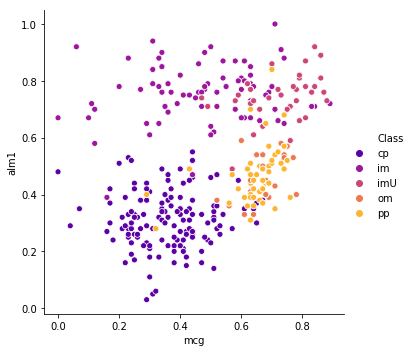

In [96]:
#Apply oversampling method & compare Before/After
#Graph datapoints based 2 features

print("Before: ",sorted(Counter(df_2['Class']).items()))

ros = RandomOverSampler(ratio = 'auto',random_state=None)

X_new, y_new = ros.fit_sample(df_2.iloc[:,1:8], df_2.iloc[:,8])
print("After: ", sorted(Counter(y_new).items()))

data2 = pd.concat([pd.DataFrame(X_new, columns = ['mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2']), pd.DataFrame(y_new, columns = ['Class'])],axis = 1)
sns.relplot(x="mcg", y="alm1", hue = "Class", data=data2, palette = "plasma");

In [100]:
#separate data into X & y
#Vectorize Values
y_2 = data2['Class'].values
X_2 = data2.drop(['Class'], axis=1).values

#Scale features
scaler = RobustScaler()
X_2 = scaler.fit_transform(X_2)

In [103]:
#train/test split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2) #80/20 split

In [117]:
rnd_clf = RandomForestClassifier(random_state=42, 
                                 n_jobs=-1,
                                 max_depth=8,
                                 n_estimators=1000,
                                 max_features=3, 
                                 criterion='gini')

rnd_clf.fit(X_train_2, y_train_2)
y_pred_2 = rnd_clf.predict(X_test_2)
print( accuracy_score(y_test_2, y_pred_2))

0.972027972027972


In [120]:
# creating a confusion matrix 
print(pd.crosstab(y_test_2, y_pred_2, rownames=['Actual'], colnames=['Predicted']))

Predicted  cp  im  imU  om  pp
Actual                        
cp         29   0    0   0   3
im          1  29    0   0   0
imU         0   0   31   0   0
om          0   0    0  23   0
pp          0   0    0   0  27


<h3 align="center"> Interpretation of Results <h3>

 For the most part, the Random Forest algorithm appears to be doing an excellent job at predicitng the location of a protein within a bacterium. **Most misclassifications occur is between cytoplasm(cp) and periplasma(pp).** This makes sense as both environments whithin a bacterium have similar properties. The cytoplasm is within the innermembrane of a bacterium while the periplasma is a smaller cytosol containg layer inbetween the innermembrane and outtermembrane. With the addition of more robust data, this has the potential to become a very useful algorithm.